In [2]:
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import make_blobs
import numpy as np
import random 


#tf.enable_eager_execution()


def gen_cluster_data_list(Cv, Lv, Nv, Mv):
    Tr = []
    Ts = []
    C = Cv  # number of categories
    L = Lv   # number of centers
    N = Nv  # number of elements
    M = Mv  # number of dimensions
    X, y = make_blobs(n_samples=N, centers=L, n_features=M,cluster_std=.5, random_state=11)
    cmap = []
    for _ in range(L):
        cmap.append(random.randint(0,C-1))
    cols = []
    for i in range(N):
        cols.append(cmap[y[i]])

    for i in range(int(0.9*N)):
        row = [X[i,j] for j in range(M)]
        row.append(cols[i])
        Tr.append(row)
    
    for i in range(int(0.9*N)+1,N):
        row = [X[i,j] for j in range(M)]
        row.append(cols[i])
        Ts.append(row)
        
    return (Tr, Ts)

def normalize (train):
    mx = []
    mn = []
    for i in range(len(train[0])-1):
        mx.append(max([x[i] for x in train ]))
        mn.append(min([x[i] for x in train ]))
    for row in train:
        for i in range(len(row)-1):
            row[i] = (row[i] - mn[i]) / (mx[i] - mn[i]) 
    return train


def gen_data_array(Cv, Lv, Nv, Mv):
    C = Cv  # number of categories
    L = Lv   # number of centers
    N = Nv  # number of elements
    M = Mv  # number of dimensions
    (T1,T2)  = gen_cluster_data_list(C, L, N, M)

    T = normalize(T1)
    N = len(T)
    x2_train = np.zeros((N,M),dtype='float32')
    y2_train = np.zeros((N,C))
    for i in range(N):
        row = T[i]
        for j in range(M):
            x2_train[i,j] = row[j]
        y2_train[i,row[-1]] = 1

    Ts = normalize(T2)
    Ns = len(Ts)
    x2_test = np.zeros((Ns,M),dtype='float32')
    y2_test = np.zeros((Ns,C))
    for i in range(Ns):
        row = Ts[i]
        for j in range(M):
            x2_test[i,j] = row[j]
        y2_test[i, row[-1]] = 1
        
    return (x2_train,y2_train, x2_test, y2_test)

def gen_data_array_s(Cv, Lv, Nv, Mv):
    C = Cv  # number of categories
    L = Lv   # number of centers
    N = Nv  # number of elements
    M = Mv  # number of dimensions
    (T1,T2)  = gen_cluster_data_list(C, L, N, M)

    T = normalize(T1)
    N = len(T)
    x2_train = np.zeros((N,M),dtype='float32')
    y2_train = np.zeros((N,1))
    for i in range(N):
        row = T[i]
        for j in range(M):
            x2_train[i,j] = row[j]
        y2_train[i] = row[-1]

    Ts = normalize(T2)
    Ns = len(Ts)
    x2_test = np.zeros((Ns,M),dtype='float32')
    y2_test = np.zeros((Ns,1))
    for i in range(Ns):
        row = Ts[i]
        for j in range(M):
            x2_test[i,j] = row[j]
        y2_test[i] = row[-1]
        
    return (x2_train,y2_train, x2_test, y2_test)



In [109]:
#P 01

import tensorflow as tf

C= 20
L= 100
N= 20000
M= 4
H = 200
#(x_train,y_train,x_test,y_test) = gen_data_array_s(C, L, N, M)
(x_train,y_train,x_test,y_test) = gen_data_array(C, L, N, M)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(H, input_shape=(M,), activation='relu'),
  tf.keras.layers.Dense(C)
])

predictions = model(x_train[:1]).numpy()
print(x_train[:1],y_train[:1], predictions)

#loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=20)
model.evaluate(x_test,  y_test, verbose=2)


[[0.8427796  0.3063155  0.32259515 0.4594482 ]] [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] [[ 0.13938987  0.12117386 -0.10054204 -0.06972875 -0.01598643  0.02721078
   0.0271881   0.09708965 -0.04463853 -0.20115463 -0.03665181 -0.09245174
   0.09950732  0.09041606  0.06595074 -0.04448139 -0.00037787 -0.00795806
   0.16027187  0.08594341]]
Epoch 1/20
563/563 [==============================] - 1s 1ms/step - loss: 2.6402 - accuracy: 0.1641
Epoch 2/20
563/563 [==============================] - 1s 1ms/step - loss: 2.2866 - accuracy: 0.2737: 0s - loss: 2.3542 
Epoch 3/20
563/563 [==============================] - 1s 1ms/step - loss: 2.0538 - accuracy: 0.3454
Epoch 4/20
563/563 [==============================] - 1s 1ms/step - loss: 1.8466 - accuracy: 0.4032
Epoch 5/20
563/563 [==============================] - 1s 1ms/step - loss: 1.6687 - accuracy: 0.4666
Epoch 6/20
563/563 [==============================] - 1s 1ms/step - loss: 1.5129 - accuracy: 0.5342
Epoch 7/20
563/563

[0.499619722366333, 0.8749374747276306]

In [108]:
import statistics 

x = [89,89,92,91,93,82,95,89,92,93]
print (sum(x)/len(x), statistics.stdev(x))

90.5 3.5978388574871505


In [72]:

from tensorflow.keras.layers import Dense
from tensorflow.keras import Model

class NN_Model(Model):
    
  def __init__(self,c,l,n,m,h):
    self.C=c
    self.L=l
    self.N=n
    self.M=m
    self.H = h
    super(NN_Model, self).__init__()
    self.d1 = Dense(self.H, input_shape=(self.M,), activation='relu')
    self.d2 = Dense(self.C)

  def call(self, x):
    x = self.d1(x)
    return self.d2(x)

@tf.function
def train_step(datas, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(datas, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

@tf.function
def test_step(datas, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(datas, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

    
C=6
L=50
N=5000
M=6
H = 100

# Create an instance of the model
model = NN_Model(C,L,N,M,H)

loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
#loss_object = tf.keras.losses.CategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

(x_train,y_train,x_test,y_test) = gen_data_array(C, L, N, M)
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).batch(32)
print (train_ds)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

    
EPOCHS = 20

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for datas, labels in train_ds:
    train_step(datas, labels)

  for test_datas, test_labels in test_ds:
    test_step(test_datas, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )    


<BatchDataset shapes: ((None, 6), (None, 6)), types: (tf.float32, tf.float64)>
Epoch 1, Loss: 1.6871731281280518, Accuracy: 32.511112213134766, Test Accuracy: 38.87775421142578
Epoch 2, Loss: 1.5367039442062378, Accuracy: 42.42222213745117, Test Accuracy: 45.090179443359375
Epoch 3, Loss: 1.4170019626617432, Accuracy: 47.22222137451172, Test Accuracy: 47.09418869018555
Epoch 4, Loss: 1.3059953451156616, Accuracy: 51.5333366394043, Test Accuracy: 52.705413818359375
Epoch 5, Loss: 1.1985323429107666, Accuracy: 56.222225189208984, Test Accuracy: 59.91984176635742
Epoch 6, Loss: 1.0974534749984741, Accuracy: 62.82222366333008, Test Accuracy: 70.34068298339844
Epoch 7, Loss: 1.0035476684570312, Accuracy: 70.53333282470703, Test Accuracy: 73.94789123535156
Epoch 8, Loss: 0.9184168577194214, Accuracy: 74.4888916015625, Test Accuracy: 76.55310821533203
Epoch 9, Loss: 0.8415672183036804, Accuracy: 77.55555725097656, Test Accuracy: 79.15831756591797
Epoch 10, Loss: 0.7718828320503235, Accuracy: 

In [73]:
import statistics 

x = [90,95,89,95,98,87,87,89,93,92]
print (sum(x)/len(x), statistics.stdev(x))

91.5 3.719318934070233


In [3]:
# P 05
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras.activations import sigmoid

class SSLayer(tf.keras.layers.Layer):
    def __init__(self,  num_outputs,activation=sigmoid):
        super(SSLayer, self).__init__()
        self.num_outputs = num_outputs
        self.activation = activation
        
    def build(self, input_shape):  
        self.kernel = self.add_weight("kernel",
                                      shape=[int(input_shape[-1]),
                                             self.num_outputs], 
                                      initializer=tf.keras.initializers.RandomNormal(stddev=.3))
        #print ("kernel ", self.kernel)
        
        self.bias = self.add_weight("bias",
                                      shape=[self.num_outputs],
                                    initializer=tf.keras.initializers.RandomNormal(stddev=.5))
        
        #print ("bias ", self.bias)
    

    def call(self, input):
        #print ("CALL------------------------------")
        isp = input.shape
        #print ("input shape:", input.shape)
        #print (tf.ones([self.batchsize, self.num_outputs]))
        In1 = tf.transpose(input)
        #print ("In1 shape:", In1.shape)
        In2 = tf.stack([In1] * self.kernel.shape[1]) 
        #print ("In2 shape:", In2.shape)
        InD = tf.transpose(In2)
        #InD = tf.reshape(input,[isp[0],1,isp[1]])
        #print ("InD shape:", InD.shape)
        #print ("kernel shape", self.kernel.shape)
        WD = tf.stack([self.kernel] * isp[0])
        #print ("WD shape", WD.shape)
        ddd = WD - InD
        #print ("ddd shape:", ddd.shape)
        #print ("ddd:", ddd)
        dd0 = tf.math.multiply(ddd, ddd)
        #print ("dd0 shape",dd0.shape)
        dd1 = tf.math.reduce_sum(dd0, axis =1)
        #print ("dd1 shape",dd1.shape)
        dd2 = tf.cast(dd1,tf.double)
        dd3 = tf.sqrt(dd2)
        dd3 = tf.cast(dd3,tf.float32)
        #print ("dd3 shape",dd3.shape)
        dd4 = tf.abs(self.bias)
        result = tf.math.divide_no_nan(dd3,dd4)
        #print ("result shape",result.shape)
        #print ("before sigmoid 1", result)
        rr2 = tf.ones(result.shape) -result
        #print ("rr2 shape",rr2.shape)
        rr3 = tf.math.scalar_mul(6,rr2)
        #print ("rr3 shape",rr3.shape)
        #print ("before sigmoid", rr3)
        result = self.activation(rr3)
        #print ("result shape",result.shape)
        #print ("result", result)
        return result


class NN_Model(Model):
    
  def __init__(self,c,l,n,m,h):
    self.C=c
    self.L=l
    self.N=n
    self.M=m
    self.H = h
    super(NN_Model, self).__init__()
    self.d1 = SSLayer(self.H *self.M)
    self.d2 = Dense(self.C)

  def call(self, x):
    x = self.d1(x)
    #print ("call benn:",x, tf.math.reduce_sum(x))
    return self.d2(x)

@tf.function
def train_step(datas, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(datas, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

@tf.function
def test_step(datas, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    
    predictions = model(datas, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

C = 2
L = 25
N = 5000
M = 6
H = 5

# Create an instance of the model
model = NN_Model(C,L,N,M,H)

loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
#loss_object = tf.keras.losses.CategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

(x_train,y_train,x_test,y_test) = gen_data_array(C, L, N, M)
print (x_train[:2])
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).batch(32)
#print (train_ds)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

    
EPOCHS = 20


for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for datas, labels in train_ds:
    train_step(datas, labels)

  for test_datas, test_labels in test_ds:
    #print ("test_data_shape", test_datas.shape)
    predictions = model(test_datas, training=False)
    #print ("ttttttttttttttttttt")
    #for i in range(test_datas.shape[0]):
        #print (predictions.numpy()[i], test_labels.numpy()[i])
    test_step(test_datas, test_labels)
    

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )    


[[0.6351555  0.79764634 0.5939905  0.91915816 0.41782913 0.74676895]
 [0.4205275  0.95162773 0.55689424 0.95857877 0.56735116 0.21881728]]
Epoch 1, Loss: 0.686540424823761, Accuracy: 53.46666717529297, Test Accuracy: 62.324649810791016
Epoch 2, Loss: 0.6422877907752991, Accuracy: 66.73332977294922, Test Accuracy: 65.33065795898438
Epoch 3, Loss: 0.5584124326705933, Accuracy: 66.44444274902344, Test Accuracy: 63.927852630615234
Epoch 4, Loss: 0.5110766887664795, Accuracy: 66.97777557373047, Test Accuracy: 65.9318618774414
Epoch 5, Loss: 0.47429782152175903, Accuracy: 70.80000305175781, Test Accuracy: 68.336669921875
Epoch 6, Loss: 0.4326953887939453, Accuracy: 76.15555572509766, Test Accuracy: 71.94388580322266
Epoch 7, Loss: 0.3913106918334961, Accuracy: 83.82221984863281, Test Accuracy: 81.7635269165039
Epoch 8, Loss: 0.3508906066417694, Accuracy: 90.22222137451172, Test Accuracy: 90.58116149902344
Epoch 9, Loss: 0.31460514664649963, Accuracy: 94.19999694824219, Test Accuracy: 93.5871

In [126]:
import statistics 

x = [100,100,100,100,100]
print (sum(x)/len(x), statistics.stdev(x))

89.2 5.750362307426086


In [18]:
# P 04
from tensorflow.keras.activations import sigmoid

class SSLayer(tf.keras.layers.Layer):
    def __init__(self, num_inputs, num_outputs,activation=sigmoid):
        super(SSLayer, self).__init__()
        self.num_outputs = num_outputs
        self.kernel = self.add_weight("kernel",
                                      shape=[num_inputs,
                                             self.num_outputs], 
                                      initializer=tf.keras.initializers.RandomNormal(stddev=.3))
        
        self.bias = self.add_weight("bias",
                                      shape=[self.num_outputs],
                                    initializer=tf.keras.initializers.RandomNormal(stddev=.5))
        
        self.activation = activation

    def call(self, input):
        print ("kernel", self.kernel)
        print ("bias", self.bias)
        ddi = tf.multiply( tf.transpose(input), tf.ones([1, self.num_outputs]) )
        print ("ddi", ddi)
        ddd = self.kernel-ddi
        print ("ddd", ddd)
        dd0 = tf.math.multiply(ddd, ddd)
        print ("dd0", dd0)
        dd1 = tf.math.reduce_sum(dd0, axis =0)
        print ("dd1", dd1)
        dd2 = tf.cast(dd1,tf.double)
        print ("dd2", dd2)
        dd3 = tf.sqrt(dd2)
        dd3 = tf.cast(dd3,tf.float32)
        print ("dd3", dd3)
        dd4 = tf.abs(self.bias)
        print ("dd4", dd4)
        result = tf.math.divide_no_nan(dd3,dd4)    
        print ("result", result)
        rr2 = tf.ones([1, self.num_outputs]) -result
        print ("rr2", rr2)
        rr3 = tf.math.scalar_mul(6,rr2)
        print ("rr3", rr3)
        result = self.activation(rr3)
        print ("result", result)
        return result

M_input = 3
M_ouput = 5
#layer = SSLayer(M_input, M_ouput)
layer = SSLayer(M_input, M_ouput,activation=sigmoid)

print([var.name for var in layer.trainable_variables])

a = np.array([[0.2, 0.3, 0.4]],dtype="float32")
print ("out:")
print (layer(tf.constant(a)))



['kernel:0', 'bias:0']
out:
kernel <tf.Variable 'kernel:0' shape=(3, 5) dtype=float32, numpy=
array([[ 0.2523557 , -0.4805397 , -0.23506409,  0.3204259 ,  0.08248037],
       [-0.04309471, -0.03324677, -0.0968312 , -0.27222425,  0.2576189 ],
       [ 0.2890751 ,  0.2100241 , -0.10678596,  0.07982869, -0.51990956]],
      dtype=float32)>
bias <tf.Variable 'bias:0' shape=(5,) dtype=float32, numpy=
array([-0.15722479,  0.3852226 ,  0.24986114,  0.3118788 ,  0.06286097],
      dtype=float32)>
ddi tf.Tensor(
[[0.2 0.2 0.2 0.2 0.2]
 [0.3 0.3 0.3 0.3 0.3]
 [0.4 0.4 0.4 0.4 0.4]], shape=(3, 5), dtype=float32)
ddd tf.Tensor(
[[ 0.05235569 -0.6805397  -0.43506408  0.12042589 -0.11751963]
 [-0.3430947  -0.33324677 -0.3968312  -0.57222426 -0.04238111]
 [-0.1109249  -0.1899759  -0.506786   -0.32017133 -0.9199096 ]], shape=(3, 5), dtype=float32)
dd0 tf.Tensor(
[[0.00274112 0.46313432 0.18928075 0.0145024  0.01381086]
 [0.11771398 0.11105341 0.15747501 0.3274406  0.00179616]
 [0.01230433 0.03609084 0

In [66]:
#P 03


class SSLayer(tf.keras.layers.Layer):
    def __init__(self, num_outputs):
        super(SSLayer, self).__init__()
        self.num_outputs = num_outputs

    def build(self, input_shape):
        self.kernel = self.add_weight("kernel",
                                      shape=[int(input_shape[-1]),
                                             self.num_outputs], 
                                      initializer=tf.keras.initializers.RandomNormal(stddev=4))
        
        self.bias = self.add_weight("bias",
                                      shape=[self.num_outputs])

    def call(self, input):
        return tf.matmul(input, self.kernel)

M_input = 3
M_ouput = 5
layer = SSLayer(M_ouput)

print([var.name for var in layer.trainable_variables])

a = np.array([[1.0, 2.3, 3.0]],dtype="float32")
print (layer(tf.constant(a)))

print([var.name for var in layer.trainable_variables])
print (layer.kernel, layer.bias)


[]
tf.Tensor([[ 10.911133    6.1613445 -17.000881   -8.46829   -11.545963 ]], shape=(1, 5), dtype=float32)
['ss_layer_13/kernel:0', 'ss_layer_13/bias:0']
<tf.Variable 'ss_layer_13/kernel:0' shape=(3, 5) dtype=float32, numpy=
array([[ 6.808793  , -2.8096771 , -0.8926972 ,  1.2995508 ,  4.6321363 ],
       [ 2.1581118 , -3.11415   ,  0.6261549 , -0.4685134 ,  0.15324706],
       [-0.28710544,  5.3778553 , -5.8494463 , -2.8967533 , -5.510189  ]],
      dtype=float32)> <tf.Variable 'ss_layer_13/bias:0' shape=(5,) dtype=float32, numpy=
array([ 0.15592939, -0.21368217, -0.21329248, -0.38312   , -0.35173374],
      dtype=float32)>


In [144]:
#P 02
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model

class NN_Model(Model):
    
  def __init__(self,c,l,n,m,h):
    self.C=c
    self.L=l
    self.N=n
    self.M=m
    self.H = h
    super(NN_Model, self).__init__()
    self.d1 = Dense(self.H*self.M, input_shape=(self.M,), activation='relu')
    self.d2 = Dense(self.C)

  def call(self, x):
    x = self.d1(x)
    return self.d2(x)

@tf.function
def train_step(datas, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(datas, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

@tf.function
def test_step(datas, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(datas, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

    
# Create an instance of the model
model = NN_Model(2,25,5000,6,5)

loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
#loss_object = tf.keras.losses.CategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

(x_train,y_train,x_test,y_test) = gen_data_array(C, L, N, M)
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).batch(32)
print (train_ds)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

    
EPOCHS = 20

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for datas, labels in train_ds:
    train_step(datas, labels)

  for test_datas, test_labels in test_ds:
    test_step(test_datas, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )    


<BatchDataset shapes: ((None, 6), (None, 2)), types: (tf.float32, tf.float64)>
Epoch 1, Loss: 0.632636547088623, Accuracy: 64.4888916015625, Test Accuracy: 82.36473083496094
Epoch 2, Loss: 0.5692639946937561, Accuracy: 78.37777709960938, Test Accuracy: 77.95591735839844
Epoch 3, Loss: 0.5161746144294739, Accuracy: 78.11111450195312, Test Accuracy: 78.55711364746094
Epoch 4, Loss: 0.46758130192756653, Accuracy: 79.33333587646484, Test Accuracy: 83.567138671875
Epoch 5, Loss: 0.42363086342811584, Accuracy: 81.06666564941406, Test Accuracy: 88.37675476074219
Epoch 6, Loss: 0.38263243436813354, Accuracy: 83.68888854980469, Test Accuracy: 92.58516693115234
Epoch 7, Loss: 0.34448081254959106, Accuracy: 87.06666564941406, Test Accuracy: 93.58717346191406
Epoch 8, Loss: 0.30898571014404297, Accuracy: 90.13333129882812, Test Accuracy: 94.7895736694336
Epoch 9, Loss: 0.2763032615184784, Accuracy: 91.5999984741211, Test Accuracy: 96.1923828125
Epoch 10, Loss: 0.24705345928668976, Accuracy: 92.711

In [145]:
import statistics 

x = [95,100,98,99,100,100,99,100]
print (sum(x)/len(x), statistics.stdev(x))

98.875 1.7268882005337975


In [135]:
#P 01

import tensorflow as tf

C=2
L=25
N=5000
M=6
H = 5
#(x_train,y_train,x_test,y_test) = gen_data_array_s(C, L, N, M)
(x_train,y_train,x_test,y_test) = gen_data_array(C, L, N, M)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(H*M, input_shape=(M,), activation='relu'),
  tf.keras.layers.Dense(C)
])

predictions = model(x_train[:1]).numpy()
print(x_train[:1],y_train[:1], predictions)

#loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=20)
model.evaluate(x_test,  y_test, verbose=2)


[[0.6351555  0.79764634 0.5939905  0.91915816 0.41782913 0.74676895]] [[0. 1.]] [[-0.5523259  -0.40917388]]
Epoch 1/20
141/141 [==============================] - 0s 766us/step - loss: 0.5966 - accuracy: 0.6662
Epoch 2/20
141/141 [==============================] - 0s 744us/step - loss: 0.5471 - accuracy: 0.7004
Epoch 3/20
141/141 [==============================] - 0s 702us/step - loss: 0.5087 - accuracy: 0.7658
Epoch 4/20
141/141 [==============================] - 0s 730us/step - loss: 0.4666 - accuracy: 0.7889
Epoch 5/20
141/141 [==============================] - 0s 766us/step - loss: 0.4238 - accuracy: 0.8027
Epoch 6/20
141/141 [==============================] - 0s 731us/step - loss: 0.3838 - accuracy: 0.8262
Epoch 7/20
141/141 [==============================] - 0s 723us/step - loss: 0.3483 - accuracy: 0.8564
Epoch 8/20
141/141 [==============================] - 0s 738us/step - loss: 0.3147 - accuracy: 0.8873
Epoch 9/20
141/141 [==============================] - 0s 709us/step - loss: 

[0.09563780575990677, 1.0]

In [136]:
import statistics 

x = [96,95,96,99,99,98,99,99,99]
print (sum(x)/len(x), statistics.stdev(x))

97.77777777777777 1.6414763002993509


In [28]:
import math

mnist = tf.keras.datasets.mnist
x = tf.constant(3.0)
c1 = tf.constant(1.0)

with tf.GradientTape() as g:
    g.watch(x)
    #y = tf.math.sin(x * x)
    y = tf.math.divide(c1, c1 + tf.math.exp(-x))
dy_dx = g.gradient(y, x) 
print(dy_dx)


tf.Tensor(0.04517666, shape=(), dtype=float32)


In [8]:
a = np.array([[1, 2, 3], [1,4,1]])
ta = tf.constant(a)
b = np.array([[3, 2, 1],[1,3,2]])
tb = tf.constant(b)
tm = tf.math.multiply(ta-tb, ta-tb)
dd = tf.math.reduce_sum(tm, axis =1)
d2 = tf.cast(dd,tf.double)
d3 = tf.sqrt(d2)
dr = tf.fill([2], 2)
dr2= tf.cast(dr,tf.double)
print (dr)
out = tf.math.divide_no_nan(d3,dr2)
print (d3)
print (out)

tf.Tensor([2 2], shape=(2,), dtype=int32)
tf.Tensor([2.82842712 1.41421356], shape=(2,), dtype=float64)
tf.Tensor([1.41421356 0.70710678], shape=(2,), dtype=float64)


In [7]:
print (tf.multiply( tf.ones([4,1]),tf.constant([1.3,3.0,5.2])))

tf.Tensor(
[[1.3 3.  5.2]
 [1.3 3.  5.2]
 [1.3 3.  5.2]
 [1.3 3.  5.2]], shape=(4, 3), dtype=float32)


In [6]:
x = tf.constant([[1, 2]])
y = tf.constant([[2], [1]])
print (x)
print (y)
z = tf.matmul(y,x)
print (z)

tf.Tensor([[1 2]], shape=(1, 2), dtype=int32)
tf.Tensor(
[[2]
 [1]], shape=(2, 1), dtype=int32)
tf.Tensor(
[[2 4]
 [1 2]], shape=(2, 2), dtype=int32)


In [18]:
x = tf.ones([3,2,2])
y = tf.constant([  [3., 2.], [4.,3.]])
print (x)
print (y)
z = tf.matmul(x,y)
print (z)

tf.Tensor(
[[[1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]]], shape=(3, 2, 2), dtype=float32)
tf.Tensor(
[[3. 2.]
 [4. 3.]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[[7. 5.]
  [7. 5.]]

 [[7. 5.]
  [7. 5.]]

 [[7. 5.]
  [7. 5.]]], shape=(3, 2, 2), dtype=float32)


In [8]:
In = tf.constant([[0.8914187,  0.44162735, 0.2808851 ],
 [0.8515105,  0.46186763, 0.24088585],
 [0.67635417, 0.07768797, 0.1056074 ],
 [0.942432,   0.7850282,  0.04864224],
 [0.13471572, 0.22203955, 0.6862668 ],
 [0.6970358,  0.06602696, 0.04721393],
 [0.06776198, 0.5567025,  0.9401386 ],
 [0.92003983, 0.8369356,  0.01939357],
 [0.8942079,  0.41677353, 0.26042283],
 [0.95389813, 0.7809099,  0.05973615]])
InD = tf.reshape(In,[10,1,3]) 
print (InD.shape)
W = tf.constant([[ 0.64815485, -0.3559605 ,  0.20014353, -0.28112715,  0.09535905,
        -0.35034025,  0.12817992, -0.5305331 ,  0.03162672, -0.08267911,
        -0.02133827,  0.07015286],
       [-0.03005282, -0.5115979 ,  0.08203132,  0.16849105,  0.4781897 ,
         0.18680447, -0.02384542, -0.03511131,  0.14952978,  0.80725867,
         0.11003426, -0.39055902],
       [ 0.32035694, -0.15671906,  0.5563809 , -0.5291747 ,  0.15807222,
        -0.5098055 ,  0.26924753,  0.06294397, -0.16664729, -0.16909388,
         0.34415245,  0.04050118]])
WD = tf.stack([W] * 10)
print (WD.shape)
R = tf.matmul(InD, WD)
print (R.shape)

(10, 1, 3)
(10, 3, 12)
(10, 1, 12)


In [10]:
vec = tf.constant([[1,2,3],[4,5,6]])  # shape=(2,3)
matrix = tf.stack([vec] * 4)  # shape=(4,2,3)


print(vec)
print(matrix)
print (tf.math.reduce_sum(matrix,0))

tf.Tensor(
[[1 2 3]
 [4 5 6]], shape=(2, 3), dtype=int32)
tf.Tensor(
[[[1 2 3]
  [4 5 6]]

 [[1 2 3]
  [4 5 6]]

 [[1 2 3]
  [4 5 6]]

 [[1 2 3]
  [4 5 6]]], shape=(4, 2, 3), dtype=int32)
tf.Tensor(
[[ 4  8 12]
 [16 20 24]], shape=(2, 3), dtype=int32)


In [57]:
import statistics 

x = [76,72,69,82,70,60,89,90,100,78]
print (sum(x)/len(x), statistics.stdev(x))

78.6 11.880890351970915


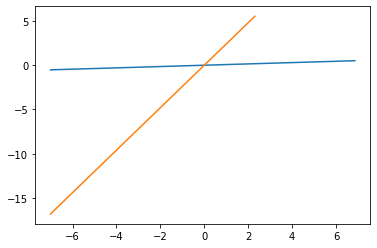

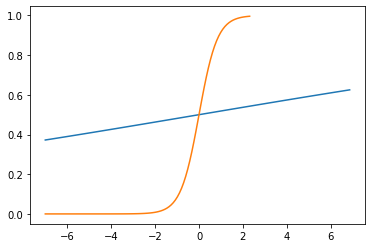

In [6]:
import math
import matplotlib.pyplot as plt

def sigm(x):
    return 1. /(1. + math.exp(-x) )
R = 80.5
T = min(7,R-.1)
X = [-T + 0.01*x*2*T for x in range(100)]
Y = [2*R/math.pi*math.tan(0.5*math.pi *x/R) for x in X]
Ys = [6*(x/R) for x in X]
#plt.plot(X,Y)
plt.plot(X,Ys)
R2 = 2.5
T2 = min(7,R2-.1)
X2 = [-T + x*((T+T2)/100)  for x in range(100)]
Y2 = [2*R2/math.pi*math.tan(0.5*math.pi *x/R2) for x in X2]
Y2s = [6*(x/R2) for x in X2]
#plt.plot(X2,Y2)
plt.plot(X2,Y2s)
plt.show()
Z = [sigm(x) for x in Y]
Zs = [sigm(x) for x in Ys]
#plt.plot(X,Z)
plt.plot(X,Zs)
Z2 = [sigm(x) for x in Y2]
Z2s = [sigm(x) for x in Y2s]
#plt.plot(X2,Z2)
plt.plot(X2,Z2s)
plt.show()


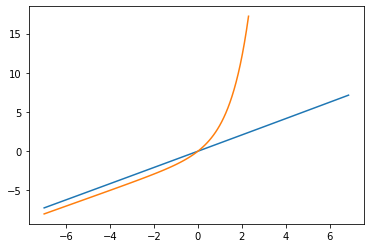

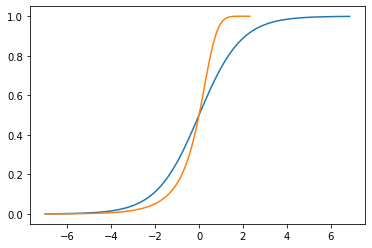

In [7]:
import math
import matplotlib.pyplot as plt

def sigm(x):
    return 1. /(1. + math.exp(-x) )
R = 80.5
T = min(7,R-.1)
X = [-T + x*(2*T/100) for x in range(100)]
Y = [x + math.exp(3*x/R) - 1 for x in X]
plt.plot(X,Y)
R2 = 2.5
T2 = min(7,R2-.1)
X2 = [-T + x*((T+T2)/100)  for x in range(100)]
Y2 = [x + math.exp(3*x/R2) -1 for x in X2]
plt.plot(X2,Y2)
plt.show()
Z = [sigm(x) for x in Y]
plt.plot(X,Z)
Z2 = [sigm(x) for x in Y2]
plt.plot(X2,Z2)
plt.show()
